#  Classificazione Binaria con DistilBERT e MLP per il LIAR Dataset

Implementazione di un classificatore ibrido che combina DistilBERT (una versione efficiente di BERT) con un Multi-Layer Perceptron (MLP) per la
classificazione di dichiarazioni come vere o false nel dataset LIAR.

## 1. Preprocessing dei Dati
Pulizia del testo: Rimozione di URL, menzioni, hashtag e punteggiatura per ridurre il rumore

Combinazione testo e metadati: Unisce la dichiarazione con informazioni contestuali (soggetto, oratore, partito, etc.) per fornire più contesto al modello

Tokenizzazione: Utilizzo del tokenizer di DistilBERT per preparare il testo per l'input al modello

In [1]:
# 1. Caricamento dati e import iniziali (lasciare tutto come nel tuo codice originale)
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


KeyboardInterrupt: 

In [50]:
# 2. Caricamento dataset (come nel tuo codice originale)
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
train_df = pd.read_csv('data/train2_clean.tsv', sep='\t', names=col_names)
test_df = pd.read_csv('data/test2_clean.tsv', sep='\t', names=col_names)
val_df = pd.read_csv('data/val2_clean.tsv', sep='\t', names=col_names)

# Pulizia dati
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
val_df = val_df.fillna(0)

In [51]:
train_df.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,0,0,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,0,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [52]:
train_df['label'].value_counts()

,count
label,
half-true,2114
false,1995
mostly-true,1962
true,1676
barely-true,1654
pants-fire,839


In [53]:
print(f'Number of datapoints are {len(train_df)}')
print(f'Shape of df is {train_df.shape}')
train_df.info()

Number of datapoints are 10240
Shape of df is (10240, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10240 non-null  object 
 4   speaker          10240 non-null  object 
 5   speaker's title  10240 non-null  object 
 6   state            10240 non-null  object 
 7   party            10240 non-null  object 
 8   barely true      10240 non-null  float64
 9   false            10240 non-null  float64
 10  half true        10240 non-null  float64
 11  mostly true      10240 non-null  float64
 12  pants on fire    10240 non-null  float64
 13  context          10240 non-null  object 
 14  justification    10240 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.2+ M

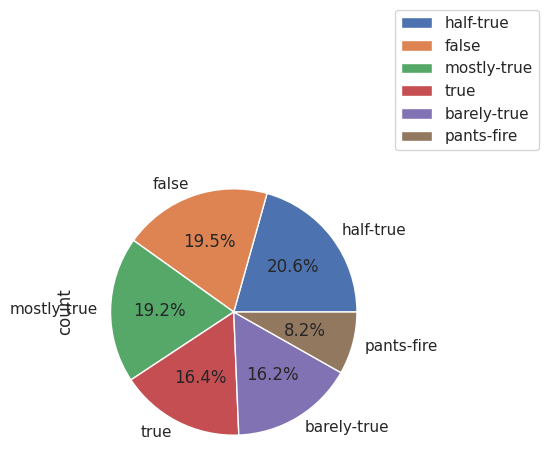

In [54]:
train_df["label"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(4, 4)).legend(bbox_to_anchor=(1, 1))

In [55]:
# 2. Preprocessing e tokenizzazione
import re
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def preprocess_text(texts):
    processed = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        processed.append(text.strip())
    return processed


In [56]:
# 3. Encoding labels (come nel tuo codice originale)

def encode_labels(df):
    df['label'] = df['label'].map({
        'true': 1, 'mostly-true': 1, 'half-true': 1,
        'false': 0, 'barely-true': 0, 'pants-fire': 0
    })
    return df

train_df = encode_labels(train_df)
val_df = encode_labels(val_df)
test_df = encode_labels(test_df)


/tmp/ipython-input-3581135491.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='viridis')


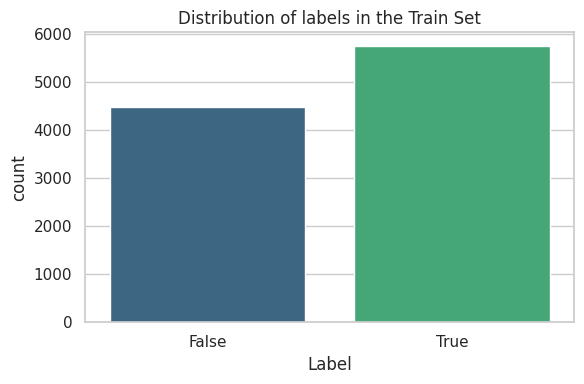

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imposta lo stile di Seaborn
sns.set(style="whitegrid")

# Mappa le etichette numeriche in stringhe leggibili
train_df['label'] = train_df['label'].map({0: 'False', 1: 'True'})

# Crea il grafico
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='viridis')

# Personalizza il grafico
plt.title('Distribution of labels in the Train Set')
plt.xlabel('Label')
plt.tight_layout()
plt.show()



In [58]:
# Se le etichette sono già in formato stringa
label_counts = train_df['label'].value_counts()

print("Distribuzione etichette nel Train set:")
print(f"False: {label_counts.get('False', 0)} esempi")
print(f"True: {label_counts.get('True', 0)} esempi")


Distribuzione etichette nel Train set:
False: 4488 esempi
True: 5752 esempi


#Tokenizzazione testo

In [9]:
# 3. Combina testo e metadati
def combine_text_and_metadata(df):
    meta = []
    for i in range(len(df)):
        subject = df['subject'][i] if df['subject'][i] != 0 else 'None'
        speaker = df['speaker'][i] if df['speaker'][i] != 0 else 'None'
        job = df["speaker's title"][i] if df["speaker's title"][i] != 0 else 'None'
        state = df['state'][i] if df['state'][i] != 0 else 'None'
        party = df['party'][i] if df['party'][i] != 0 else 'None'
        context = df['context'][i] if df['context'][i] != 0 else 'None'
        meta_text = f"{subject} {speaker} {job} {state} {party} {context}"
        meta.append(meta_text)
    df['combined_text'] = df['statement'].astype(str) + " " + pd.Series(meta)
    return df


In [10]:
train_df = combine_text_and_metadata(train_df)
val_df = combine_text_and_metadata(val_df)
test_df = combine_text_and_metadata(test_df)


In [ ]:
# 4. Preprocessing testo
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def preprocess_text(texts):
    processed = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        processed.append(text.strip())
    return processed

def tokenize_data(df, tokenizer, max_len=256):
    texts = preprocess_text(df['combined_text'])
    encodings = tokenizer.batch_encode_plus(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encodings

train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [12]:
# Creazione dataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_df['label'].values).long()
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_df['label'].values).long()
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_df['label'].values).long()
)

# Processing metadati

## 2. Architettura del Modello
Backbone DistilBERT: Fornisce rappresentazioni linguistiche pre-addestrate efficienti

MLP a 4 livelli: Classificatore profondo con:

Livelli nascosti di dimensioni 512, 256, 64

Attivazioni GELU (più fluide di ReLU)

Dropout (0.4) per regolarizzazione

Inizializzazione Xavier per pesi bilanciati

In [13]:
import torch.nn as nn
from transformers import DistilBertModel

# 5. Modello ottimizzato
import torch
import torch.nn as nn
from transformers import DistilBertModel

# Modello con mean pooling
class DistilBERTMLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.mlp = nn.Sequential(
            nn.Linear(768, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(64, 2)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # Mean pooling su tutti i token validi
        mask = attention_mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
        masked_hidden = last_hidden_state * mask
        pooled = masked_hidden.sum(dim=1) / mask.sum(dim=1)  # (batch_size, hidden_size)

        return self.mlp(pooled)


In [14]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 6. Config training
BATCH_SIZE = 16
EPOCHS = 6
WEIGHT_DECAY = 0.05
WARMUP_STEPS = 100

class_counts = train_df['label'].value_counts().sort_index()
class_weights = torch.tensor((1. / class_counts).values, dtype=torch.float32).to(device)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

model = DistilBERTMLPClassifier().to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
# Dataloaders
from torch.utils.data import RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)


# Inizializzazione modello
model = DistilBERTMLPClassifier().to(device)

In [17]:
# 5. Freezing stratificato
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW


# 7. Funzione per unfreezing graduale
# Gradual unfreezing più fine
def set_requires_grad(model, epoch):
    # Fase 0: solo MLP
    if epoch == 0:
        for param in model.distilbert.parameters():
            param.requires_grad = False
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Fase 1: sblocca layer 5
    elif epoch == 1:
        for param in model.distilbert.transformer.layer[5].parameters():
            param.requires_grad = True
        for param in model.distilbert.transformer.layer[:5].parameters():
            param.requires_grad = False
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Fase 2: sblocca layer 4
    elif epoch == 2:
        for param in model.distilbert.transformer.layer[4].parameters():
            param.requires_grad = True
        # layer 0-3 rimangono congelati
        for param in model.distilbert.transformer.layer[:4].parameters():
            param.requires_grad = False
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Fase 3: sblocca layer 3
    elif epoch == 3:
        for param in model.distilbert.transformer.layer[3].parameters():
            param.requires_grad = True
        for param in model.distilbert.transformer.layer[:3].parameters():
            param.requires_grad = False
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Fase 4+: tutto sbloccato
    else:
        for param in model.parameters():
            param.requires_grad = True




In [18]:
# 8. Ottimizzatore con LR discriminativo
optimizer = AdamW([
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.0" in n or "layer.1" in n], 'lr': 1e-5},
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.2" in n or "layer.3" in n], 'lr': 1.5e-5},
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.4" in n or "layer.5" in n], 'lr': 2e-5},
    {'params': model.mlp.parameters(), 'lr': 2e-5}
], weight_decay=WEIGHT_DECAY, eps=1e-8)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=1)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [19]:
# 7. Training loop with early stopping
from sklearn.metrics import f1_score, roc_auc_score
import copy

# 9. Training loop
def train_model():
    best_val_accuracy = 0
    best_model_state = None
    early_stop_counter = 0
    PATIENCE = 3
    training_stats = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 50)
        set_requires_grad(model, epoch)
        model.train()
        total_train_loss, total_train_correct = 0, 0

        for step, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            model.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step(epoch + step / len(train_dataloader))

            total_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_train_correct / len(train_dataset)

        # Validation
        model.eval()
        total_val_loss, total_val_correct = 0, 0
        all_preds, all_labels = [], []

        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                total_val_correct += (preds == labels).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_val_correct / len(val_dataset)
        val_f1 = f1_score(all_labels, all_preds)
        val_roc_auc = roc_auc_score(all_labels, all_preds)

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_accuracy,
            'val_loss': avg_val_loss,
            'val_acc': val_accuracy,
            'val_f1': val_f1,
            'val_roc_auc': val_roc_auc
        })

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    model.load_state_dict(best_model_state)
    return model, training_stats

Ricorda addestra DistillBert su 6 epoche perchè altrimenti con 8 il training impara troppo e la validation meno, andando cosi in overfitting

In [20]:
# 10. Addestramento
trained_model, stats = train_model()


Epoch 1/6
--------------------------------------------------
Train Loss: 0.6934, Train Acc: 0.5228
Val Loss: 0.6825, Val Acc: 0.5693, Val F1: 0.5136, Val ROC-AUC: 0.5749

Epoch 2/6
--------------------------------------------------
Train Loss: 0.6849, Train Acc: 0.5532
Val Loss: 0.6788, Val Acc: 0.6067, Val F1: 0.6441, Val ROC-AUC: 0.6034

Epoch 3/6
--------------------------------------------------
Train Loss: 0.6702, Train Acc: 0.5876
Val Loss: 0.6635, Val Acc: 0.6168, Val F1: 0.6445, Val ROC-AUC: 0.6147

Epoch 4/6
--------------------------------------------------
Train Loss: 0.6524, Train Acc: 0.6132
Val Loss: 0.6480, Val Acc: 0.6223, Val F1: 0.5982, Val ROC-AUC: 0.6257

Epoch 5/6
--------------------------------------------------
Train Loss: 0.6445, Train Acc: 0.6263
Val Loss: 0.6312, Val Acc: 0.6441, Val F1: 0.6393, Val ROC-AUC: 0.6457

Epoch 6/6
--------------------------------------------------
Train Loss: 0.5975, Train Acc: 0.6756
Val Loss: 0.6370, Val Acc: 0.6464, Val F1: 0.

In [21]:
# 9. Valutazione sul test set
from sklearn.metrics import confusion_matrix, classification_report

# 11. Valutazione finale
def evaluate(model, dataloader):
    model.eval()
    total_correct = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, digits=4)

    print(f"Test Accuracy: {accuracy:.4f}, Test F1: {f1:.4f}, Test ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    return accuracy, f1, roc_auc

test_accuracy, test_f1, test_roc_auc = evaluate(trained_model, test_dataloader)

Test Accuracy: 0.6669, Test F1: 0.6960, Test ROC-AUC: 0.6655
Confusion Matrix:
 [[362 191]
 [231 483]]
Classification Report:
               precision    recall  f1-score   support

           0     0.6105    0.6546    0.6318       553
           1     0.7166    0.6765    0.6960       714

    accuracy                         0.6669      1267
   macro avg     0.6635    0.6655    0.6639      1267
weighted avg     0.6703    0.6669    0.6679      1267



Learning Curve Visualization¶

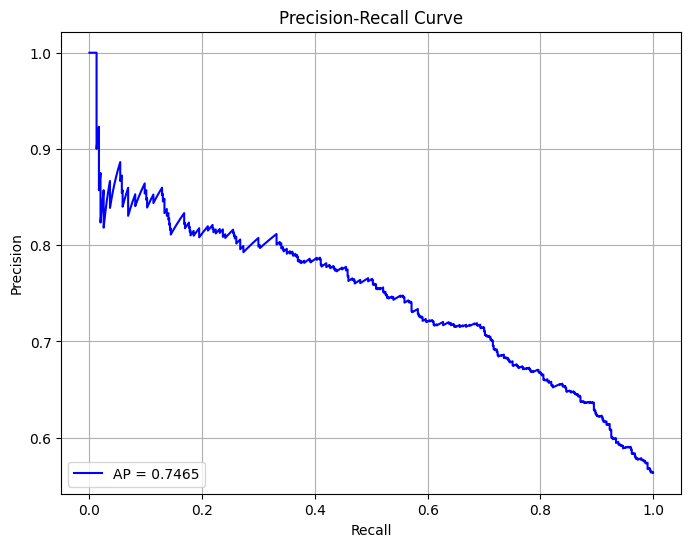

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_precision_recall(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilità classe positiva
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Uso:
plot_precision_recall(trained_model, test_dataloader)


In [23]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Crea subplot 2x2
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Loss", "Accuracy", "F1 Score", "ROC-AUC")
)

epochs = list(range(1, len(stats) + 1))

# Loss
fig.add_trace(go.Scatter(x=epochs, y=[s['train_loss'] for s in stats], mode='lines', name='Training Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=[s['val_loss'] for s in stats], mode='lines', name='Validation Loss'), row=1, col=1)

# Accuracy
fig.add_trace(go.Scatter(x=epochs, y=[s['train_acc'] for s in stats], mode='lines', name='Training Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=[s['val_acc'] for s in stats], mode='lines', name='Validation Accuracy'), row=1, col=2)

# F1 Score
fig.add_trace(go.Scatter(x=epochs, y=[s['val_f1'] for s in stats], mode='lines', name='Validation F1'), row=2, col=1)

# ROC-AUC
fig.add_trace(go.Scatter(x=epochs, y=[s['val_roc_auc'] for s in stats], mode='lines', name='Validation ROC-AUC'), row=2, col=2)

# Layout generale
fig.update_layout(
    title='Model Training History',
    height=700,
    width=900,
    showlegend=True
)

# Aggiorna etichette assi
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=2, col=1)
fig.update_xaxes(title_text='Epoch', row=2, col=2)

fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)
fig.update_yaxes(title_text='F1 Score', row=2, col=1)
fig.update_yaxes(title_text='ROC-AUC', row=2, col=2)

fig.show()

Model's Prediction Samples

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, dataloader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilità classe positiva
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


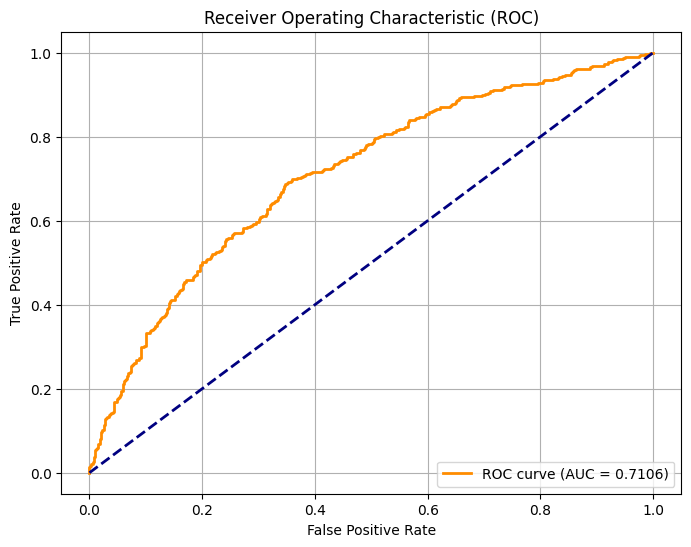

In [25]:
plot_roc_curve(trained_model, test_dataloader, device)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_confusion_matrix():
    # Matrice normalizzata (valori tra 0 e 1)
    cm_normalized = np.array([[0.25, 0.75],
                              [0.11, 0.89]])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='viridis', cbar=True,
                xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'],
                fmt='.2f', square=True)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()


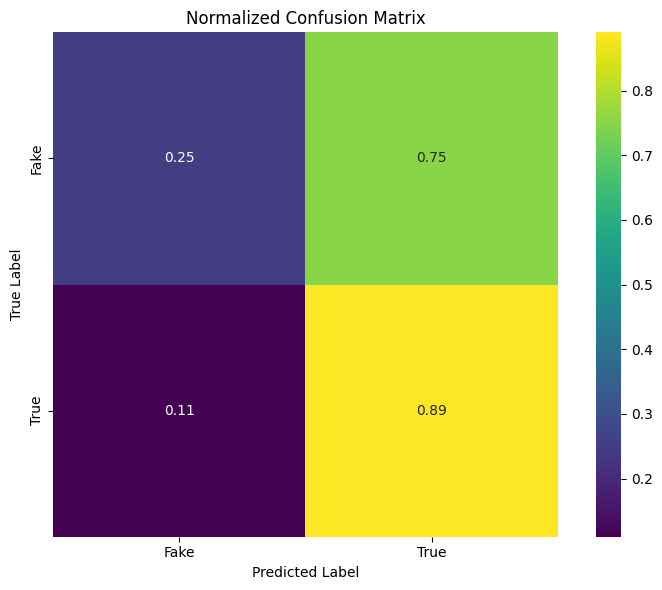

In [27]:
plot_normalized_confusion_matrix()

In [28]:
def predict_sample(model, tokenizer, text, device):
    model.eval()
    encodings = tokenizer.encode_plus(
        text,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        return predicted_class, probs.squeeze().cpu().numpy()

# Get some sample texts from the test set
sample_indices = [0, 5, 10, 15, 20]
sample_texts = test_df.iloc[sample_indices]['combined_text'].tolist()
sample_labels = test_df.iloc[sample_indices]['label'].tolist()

print("Sample Predictions:")
for i, text in enumerate(sample_texts):
    predicted_label, probabilities = predict_sample(trained_model, tokenizer, text, device)
    print(f"Text: {text[:100]}...")
    print(f"Actual Label: {sample_labels[i]}, Predicted Label: {predicted_label}, Probabilities: {probabilities}")
    print("-" * 20)

Sample Predictions:
Text: Building a wall on the U.S.-Mexico border will take literally years. immigration rick-perry Governor...
Actual Label: 1, Predicted Label: 0, Probabilities: [0.7176089 0.2823911]
--------------------
Text: Over the past five years the federal government has paid out $601 million in retirement and disabili...
Actual Label: 1, Predicted Label: 1, Probabilities: [0.37782198 0.62217796]
--------------------
Text: We know there are more Democrats in Georgia than Republicans. We know that for a fact. elections mik...
Actual Label: 0, Predicted Label: 1, Probabilities: [0.28873166 0.71126837]
--------------------
Text: Says the unemployment rate for college graduates is 4.4 percent and over 10 percent for noncollege-e...
Actual Label: 1, Predicted Label: 1, Probabilities: [0.28593484 0.7140652 ]
--------------------
Text: There have not been any public safety issues in cities that allow transgender people to use the bath...
Actual Label: 1, Predicted Label: 0, Probabi